In [1]:
from pandas import read_csv, unique

import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow import stack
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation
from keras.layers import Conv1D, LSTM, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

In [3]:
names = ['user-id', 'activity', 'timestamp', 'X', 'Y', 'Z', "NaN"]

data = pd.read_csv("/Users/kwonheejin/Documents/DL/dataset/WISDM.csv", index_col=0)


def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

df = data
df.head()

,user-id,activity,timestamp,X,Y,Z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


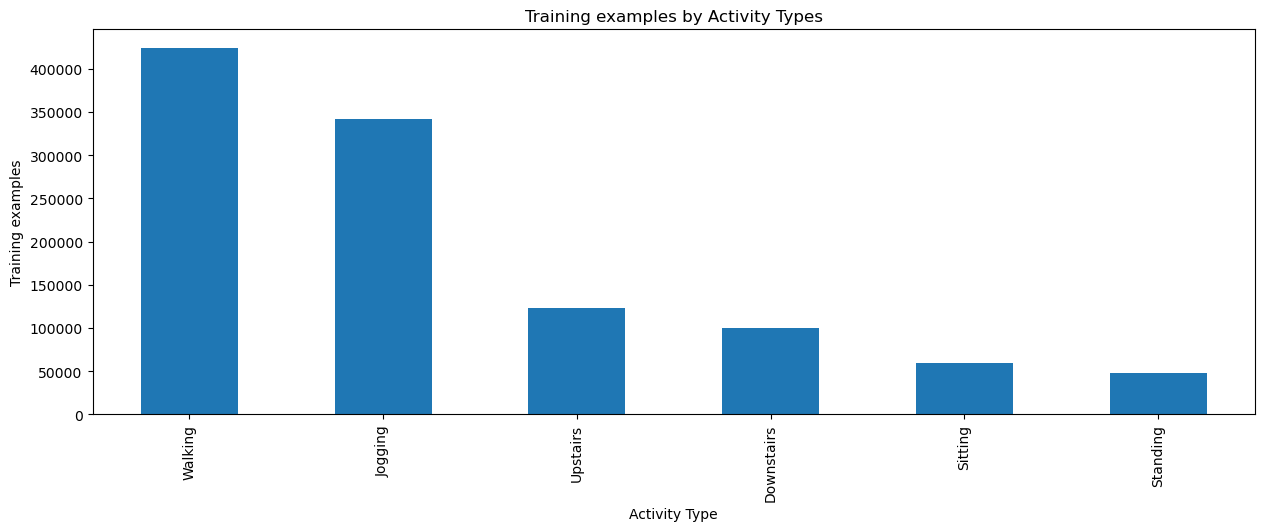

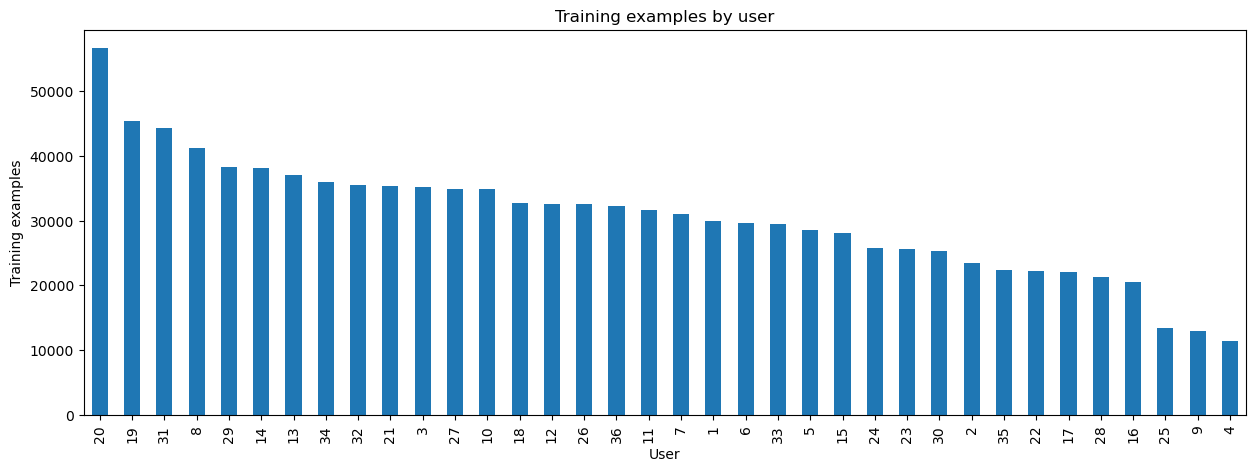

In [4]:
plt.figure(figsize=(15, 5))

plt.xlabel('Activity Type')
plt.ylabel('Training examples')
df['activity'].value_counts().plot(kind='bar',
                                  title='Training examples by Activity Types')
plt.show()

plt.figure(figsize=(15, 5))
plt.xlabel('User')
plt.ylabel('Training examples')
df['user-id'].value_counts().plot(kind='bar', 
                                 title='Training examples by user')
plt.show()

In [5]:
df.shape

(1098203, 6)

In [6]:
data.head()

,user-id,activity,timestamp,X,Y,Z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


In [7]:
# Walking = df[df['activity']=='Walking'].head(45000).copy()
Jogging = data[data['activity']=='Jogging'].head(45000).copy()
# Upstairs = df[df['activity']=='Upstairs'].head(24000).copy()
# Downstairs = df[df['activity']=='Downstairs'].head(24000).copy()
Sitting = data[data['activity']=='Sitting'].head(45000).copy()
# Standing = df[df['activity']=='Standing'].head(48000).copy()

In [8]:
Sitting.head()

,user-id,activity,timestamp,X,Y,Z
221333,27,Sitting,12363992261000,2.60,9.66,1.035146
221334,27,Sitting,12364042279000,2.68,9.53,0.503953
221335,27,Sitting,12364092267000,3.49,8.89,0.762740
221336,27,Sitting,12364142316000,3.64,9.38,0.926184
221337,27,Sitting,12364192273000,2.91,9.34,1.035146


In [9]:
Sitting.shape

(45000, 6)

In [10]:
import pandas as pd
balanced_data = pd.DataFrame()
balanced_data = pd.concat([balanced_data, Jogging, Sitting])
balanced_data.shape

(90000, 6)

In [11]:
balanced_data['activity'].value_counts()

Jogging    45000
Sitting    45000
Name: activity, dtype: int64

In [12]:
balanced_data['activity'] = balanced_data['activity'].replace({'Jogging': 1, 'Sitting': 0})

print(balanced_data['activity'].value_counts())

1    45000
0    45000
Name: activity, dtype: int64


In [13]:
balanced_data.head()

,user-id,activity,timestamp,X,Y,Z
0,33,1,49105962326000,-0.694638,12.680544,0.503953
1,33,1,49106062271000,5.012288,11.264028,0.953424
2,33,1,49106112167000,4.903325,10.882658,-0.081722
3,33,1,49106222305000,-0.612916,18.496431,3.023717
4,33,1,49106332290000,-1.184970,12.108489,7.205164


In [14]:
balanced_data = balanced_data.drop(['user-id'], axis=1)
balanced_data.head()

,activity,timestamp,X,Y,Z
0,1,49105962326000,-0.694638,12.680544,0.503953
1,1,49106062271000,5.012288,11.264028,0.953424
2,1,49106112167000,4.903325,10.882658,-0.081722
3,1,49106222305000,-0.612916,18.496431,3.023717
4,1,49106332290000,-1.184970,12.108489,7.205164


In [15]:
from sklearn.model_selection import train_test_split

# Assuming 'balanced_data' is your DataFrame with the updated 'activity' column
# Features (X) and labels (y)
# X = balanced_data.drop('activity', axis=1)  # Assuming 'activity' is the target column
# y = balanced_data['activity']

# Split the data into training and testing sets
X_train, X_test= train_test_split(balanced_data, test_size=0.2, random_state=1)
X_train, X_val= train_test_split(X_train, test_size=0.2, random_state=1)

X_train.shape, X_val.shape, X_test.shape

((57600, 5), (14400, 5), (18000, 5))

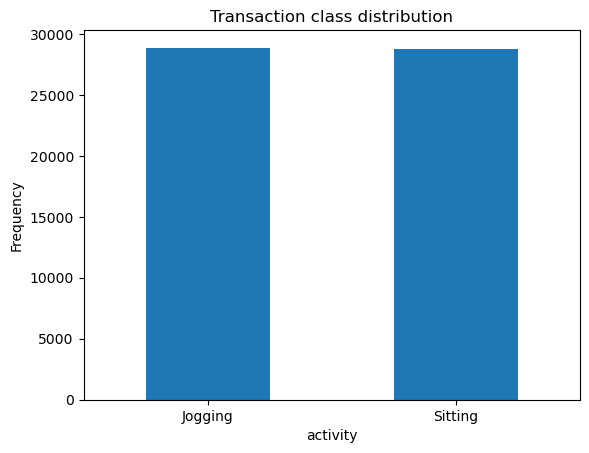

In [16]:
LABELS = ["Jogging", "Sitting"]

count_classes = pd.value_counts(X_train['activity'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("activity")
plt.ylabel("Frequency");

In [17]:
X_train = X_train[X_train.activity == 0]
X_train = X_train.drop(['activity'], axis=1)

X_val = X_val[X_val.activity == 0]
X_val = X_val.drop(['activity'], axis=1)

y_test = X_test['activity']
X_test = X_test.drop(['activity'], axis=1)

X_train = X_train.values
X_val = X_val.values
X_test = X_test.values

In [18]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Make sure to only fit the scaler on the training data
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
X_test = scaler.transform(X_test)

In [19]:
NUM_COL = 4

In [20]:
#Setting the Hyperparameters

#learning_rate = 0.00001
learning_rate = 0.0001
batch_size = 128
epochs = 5
adam = Adam(learning_rate = learning_rate, beta_1 = 0.5)

In [21]:
# Defining the Generator network

def get_generator(optimizer):
    
    generator = Sequential()
    generator.add(Dense(64, input_dim=NUM_COL, kernel_initializer=initializers.glorot_normal(seed=42)))
    generator.add(Activation('tanh'))
    
    generator.add(Dense(128))
    generator.add(Activation('tanh'))
    
    generator.add(Dense(256))
    generator.add(Activation('tanh'))
    
    generator.add(Dense(256))
    generator.add(Activation('tanh'))
       
    generator.add(Dense(512))
    generator.add(Activation('tanh'))
   
    generator.add(Dense(NUM_COL, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
    
    return generator

In [22]:
##### Defining the Discriminator network

def get_discriminator(optimizer):
    
    discriminator = Sequential()
    
    discriminator.add(Dense(256, input_dim=NUM_COL, kernel_initializer=initializers.glorot_normal(seed=42)))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))

    discriminator.add(Dense(128))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))
       
    discriminator.add(Dense(128))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))
    
    discriminator.add(Dense(128))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))

    discriminator.add(Dense(128))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))
    
    discriminator.add(Dense(1))
    discriminator.add(Activation('sigmoid'))
   
    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))

    return discriminator

In [23]:
def get_gan_network(discriminator, generator, optimizer,input_dim=NUM_COL):

    discriminator.trainable = False   
    gan_input = Input(shape=(input_dim,))  
    x = generator(gan_input)        
    gan_output = discriminator(x)
    
    gan = Model(inputs=gan_input, outputs=gan_output)    
    gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
    
    
    return gan

In [24]:
from tqdm import tqdm
from tensorflow.keras import initializers

In [25]:
#Training the GAN

#Calculating the number of batches based on the batch size
batch_count = X_train.shape[0] // batch_size
pbar = tqdm(total= epochs * batch_count)
gan_loss = []
discriminator_loss = []

#Inititalizing the network
generator = get_generator(adam)
discriminator = get_discriminator(adam)
gan = get_gan_network(discriminator, generator, adam,input_dim=NUM_COL)

for epoch in range(epochs):        
    for index in range(batch_count):        
        pbar.update(1)        
        # Creating a random set of input noise and images
        noise = np.random.normal(0, 1, size=[batch_size,NUM_COL])
        
        # Generate fake samples
        generated_images = generator.predict_on_batch(noise)
        
        #Obtain a batch of normal network packets
        image_batch = X_train[index * batch_size: (index + 1) * batch_size]
            
        X = np.vstack((generated_images,image_batch))       
        y_dis = np.ones(2*batch_size) 
        y_dis[:batch_size] = 0

        # Train discriminator
        discriminator.trainable = True
        d_loss= discriminator.train_on_batch(X, y_dis)

        # Train generator
        noise = np.random.uniform(0, 1, size=[batch_size, NUM_COL])
        y_gen = np.ones(batch_size)
        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise, y_gen)
        
        #Record the losses
        discriminator_loss.append(d_loss)
        gan_loss.append(g_loss)
        
    print("Epoch %d Batch %d/%d [D loss: %f] [G loss:%f]" % (epoch,index,batch_count, d_loss, g_loss))              

 21%|████████▏                              | 237/1125 [00:02<00:07, 113.37it/s]

Epoch 0 Batch 224/225 [D loss: 0.461422] [G loss:0.488836]


 41%|████████████████                       | 465/1125 [00:04<00:05, 112.94it/s]

Epoch 1 Batch 224/225 [D loss: 0.323879] [G loss:0.804152]


 62%|████████████████████████               | 693/1125 [00:06<00:03, 110.51it/s]

Epoch 2 Batch 224/225 [D loss: 0.313930] [G loss:0.958126]


 82%|███████████████████████████████▉       | 921/1125 [00:08<00:01, 110.43it/s]

Epoch 3 Batch 224/225 [D loss: 0.338297] [G loss:1.086614]


100%|█████████████████████████████████████▉| 1124/1125 [00:10<00:00, 109.03it/s]

Epoch 4 Batch 224/225 [D loss: 0.106171] [G loss:4.030138]


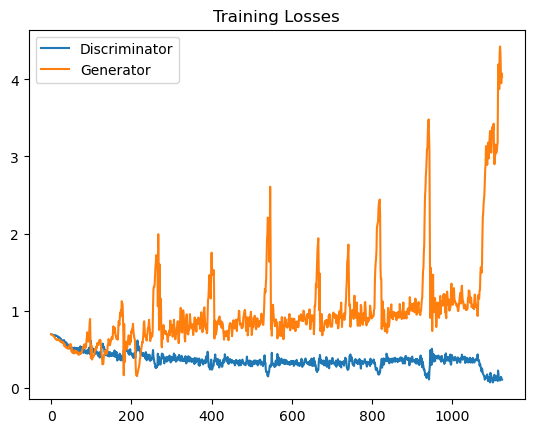

In [26]:
fig, ax = plt.subplots()
plt.plot(discriminator_loss, label='Discriminator')
plt.plot(gan_loss, label='Generator')
plt.title("Training Losses")
plt.legend()

In [27]:
# Predictions on the test set

nr_batches_test = np.ceil(X_test.shape[0] // batch_size).astype(np.int32)

results =[]

for t in range(nr_batches_test +1):    
        ran_from = t * batch_size
        ran_to = (t + 1) * batch_size
        image_batch = X_test[ran_from:ran_to]             
        tmp_rslt = discriminator.predict(x=image_batch,batch_size=128,verbose=0)        
        results = np.append(results, tmp_rslt)   

In [28]:
results

array([0.99999052, 0.99445236, 0.99999851, ..., 0.93877381, 0.99999934,
       0.99999994])

In [29]:
y2 = y_test.to_numpy()

In [30]:
pd.options.display.float_format = '{:20,.7f}'.format
results_df = pd.concat([pd.DataFrame(results),pd.DataFrame(y2)], axis=1)
results_df.columns = ['results','y_test']
print ('Mean score for Normal data :', results_df.loc[results_df['y_test'] == 1, 'results'].mean() )
print ('Mean score for Fall data :', results_df.loc[results_df['y_test'] == 0, 'results'].mean())

Mean score for Normal data : 0.6655792653613835
Mean score for Fall data : 0.9061431729929105


In [31]:
#Obtaining the lowest 1% score
per = np.percentile(results,1)
y_pred = results.copy()
y_pred = np.array(y_pred)

#Thresholding based on the score
inds = (y_pred > per)
inds_comp = (y_pred <= per)
y_pred[inds] = 0
y_pred[inds_comp] = 1

In [35]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

precision, recall, f1,_ = precision_recall_fscore_support(y_test,y_pred,average='binary')
print ('Accuracy Score :',accuracy_score(y_test, y_pred))
print ('Precision :',precision )
print ('Recall :',recall )
print ('F1 :',f1 )

Accuracy Score : 0.5096666666666667
Precision : 1.0
Recall : 0.019986675549633577
F1 : 0.039190071848465055


Confusion Matrix :


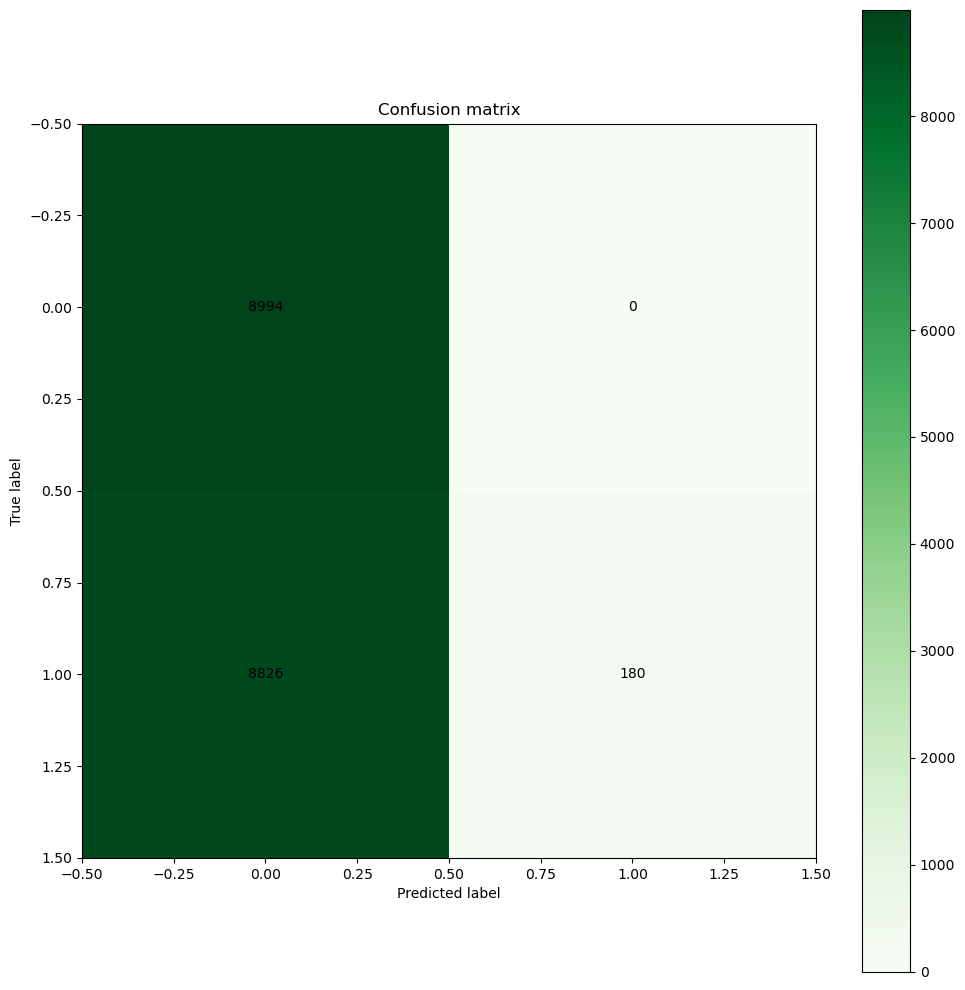

In [33]:
cm = confusion_matrix(y_test, y_pred)

print ('Confusion Matrix :')

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Greens):
    plt.figure(figsize=(10,10),)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


plot_confusion_matrix(cm)

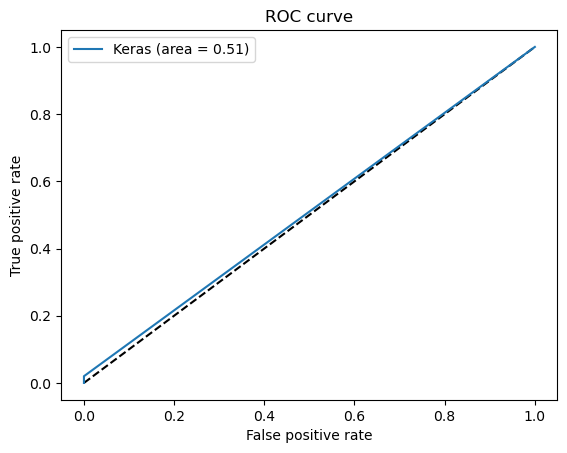

100%|██████████████████████████████████████| 1125/1125 [00:30<00:00, 109.03it/s]

In [34]:
from sklearn.metrics import roc_curve, auc

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.2f})'.format(auc_keras))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()